In [1]:
%reset
import numpy as np
import pandas as pd
import scipy.stats
import skimage.transform as tf
import pickle
from matplotlib import pyplot as plt
import math
%matplotlib inline
import matplotlib
matplotlib.style.use('ggplot')

Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.


In [220]:
img_w,img_h = (160,160)

def import_data(img_w,img_h):
    train_imgs = np.load('./data/training-data/train_imgs_{}x{}.npy'.format(img_w,img_h))[()]
        
    train_msks = np.load('./data/training-data/train_msks_{}x{}.npy'.format(img_w,img_h))[()]
        
    return train_imgs,train_msks

In [221]:
train_imgs,train_msks = import_data(img_w,img_h)

In [2]:
# Alternatiely, load the pre-augmenbted data if I'm just here to make weights.

img_w,img_h = (160,160)
x = np.load('./data/training-data/train_imgs_{}x{}_augmented_array.npy'.format(img_w,img_h),'r')
y = np.load('./data/training-data/train_msks_{}x{}_augmented_array.npy'.format(img_w,img_h),'r')

In [222]:
areas = {}
# Tally the total area for each image and each class
for imageID in train_msks.keys():
    areas[imageID] = {}
    for class_ in range(train_msks[imageID].shape[0]):
        areas[imageID][class_] = train_msks[imageID][class_].sum()
areas = pd.DataFrame(areas).transpose()
# Determine if an image contains a class
areas_binary = areas.applymap(lambda x: 1 if x > 0 else 0)
# Find the relative proportion of each class, i.e. it's relative amount in the entire data set
areas_relative = pd.DataFrame([i/areas_binary.sum().sum() for i in areas_binary.sum()],columns=['proportion'])
(1-areas_relative).std()

proportion    0.048646
dtype: float64

In [5]:
# Find how "classy" an image is, i.e. whether it contains the all the classes
# Later, images that are not very "classy" will be chosen for augmentation with a lower frequency
# This will attempt to balance the classes a little
# Images with all classes get 1.0
# Images with few classes get lower scores, however rarer classes are preferred
classiness = dict(areas_binary.apply(lambda x: x*((1-areas_relative)/(1-areas_relative).sum()).proportion,axis=1).sum(axis=1))

In [4]:
# Same as above but this is done on the augmented data set...
# The standard deviation should become lower...
# Which it does
areas = {}
for imageID in range(y.shape[0]):
    areas[imageID] = {}
    for class_ in range(y.shape[1]):
        areas[imageID][class_] = y[imageID,class_,...].sum()
areas = pd.DataFrame(areas).transpose()
areas_binary = areas.applymap(lambda x: 1 if x > 0 else 0)
areas_relative = pd.DataFrame([i/areas_binary.sum().sum() for i in areas_binary.sum()],columns=['proportion'])
(1-areas_relative).std()

proportion    0.032049
dtype: float64

In [224]:
x = np.concatenate([i[np.newaxis,...] for i in train_imgs.values()],axis=0)
y = np.concatenate([i[np.newaxis,...] for i in train_msks.values()],axis=0)
print(x.shape,y.shape)

(25, 20, 160, 160) (25, 10, 160, 160)


In [226]:
def rotater(x_rot,y_rot):
    angle = np.random.uniform(30,330)
    for channel in range(x_rot.shape[0]):
        x_rot[channel,...] = tf.rotate(x_rot[channel,...],
                          angle=angle,
                          order=0,
                          mode='reflect')
    for class_ in range(y_rot.shape[0]):
        y_rot[class_,...] = tf.rotate(y_rot[class_,...].astype(np.float32),
                          angle=angle,
                          order=0,
                          mode='reflect')
    return x_rot[np.newaxis,...], y_rot[np.newaxis,...]

In [ ]:
for i in range(375):
    mu = np.mean(list(classiness.values()))
    sigma = np.std(list(classiness.values()))
    chance = scipy.stats.truncnorm.rvs((0-mu)/sigma,(1-mu)/sigma,loc=mu,scale=sigma)
    keys = [key for key in classiness if classiness[key]>chance]
    imageID = np.random.choice(keys)
    
    
    x_rot,y_rot = train_imgs[imageID].copy(),train_msks[imageID].copy()
    x_rot,y_rot = rotater(x_rot,y_rot)
    if np.random.uniform() > 0.25: # Flip LR
        x_rot = x_rot[:,:,:,::-1]
        y_rot = y_rot[:,:,:,::-1]
    if np.random.uniform() > 0.25: # Flip LR
        x_rot = x_rot[:,:,::-1,:]
        y_rot = y_rot[:,:,::-1,:]
        
    x = np.append(x,x_rot,axis=0)
    y = np.append(y,y_rot,axis=0)
    if i % 25 == 0:
        print('{} images are done.'.format(i))
print(x.shape,y.shape)

0 images are done.
25 images are done.
50 images are done.
75 images are done.
100 images are done.
125 images are done.
150 images are done.
175 images are done.
200 images are done.
225 images are done.
250 images are done.
275 images are done.
300 images are done.
325 images are done.
350 images are done.
(400, 20, 160, 160) (400, 10, 160, 160)


In [240]:
from sklearn.utils import shuffle
x,y = shuffle(x,y,random_state=13)

In [241]:
y[y>0] = 1

In [260]:
np.save('./data/training-data/train_imgs_{}x{}_augmented_array.npy'.format(img_w,img_h),x)
np.save('./data/training-data/train_msks_{}x{}_augmented_array.npy'.format(img_w,img_h),y)

In [7]:
# Original weights function

total_area = {}
for img in range(y.shape[0]):
    for class_ in range(y.shape[1]):
        if class_ not in total_area.keys():
            total_area[class_] = 0
        total_area[class_] += y[img,class_,...].sum()
weights = [area/np.sum(list(total_area.values())) for area in total_area.values()]
#weights = {class_:((np.min(list(weights.values()))-weight)/(np.min(list(weights.values()))-np.max(list(weights.values())))) for (class_,weight) in weights.items()}

In [12]:
[(weight/np.median(weights))**-1 for weight in weights]

[memmap(0.2878025198484717),
 memmap(0.41989831880123224),
 memmap(1.8660198961686827),
 memmap(0.6830134397757914),
 memmap(0.19658051573579952),
 memmap(0.11129322140325446),
 memmap(5.4148521755858265),
 memmap(7.417518981504355),
 memmap(99.79381785951696),
 memmap(10.208062286089893)]

In [ ]:
[np.max(list(total_area.values()))/area for area in total_area.values()]

In [ ]:
np.save('./data/misc/augmented_data_class_weights.npy',weights)
weights

In [14]:
# Newer weights function

class_areas = {} # the areas of class-specific pixels
total_areas = {} # the areas of all images that contain a class
for img in range(y.shape[0]):
    for class_ in range(y.shape[1]):
        
        if class_ not in class_areas.keys():
            class_areas[class_] = 0
        class_areas[class_] += y[img,class_,...].sum()
        
        if class_ not in total_areas.keys():
            total_areas[class_] = 0
        if y[img,class_,...].max() == 1:
            total_areas[class_] += y.shape[-2]*y.shape[-1] # total area of images

freqs = [area/total_areas[class_] for (class_,area) in class_areas.items()]
weights = np.array([np.median(freqs)/freq for freq in freqs])

In [16]:
list(weights)

[0.32274321608535878,
 0.54275440609545555,
 2.0012997605050638,
 0.91864449497792977,
 0.27469955718114997,
 0.12830398669421825,
 1.0971653825596812,
 8.49943404116007,
 83.321875466694266,
 11.803989186128909]

In [5]:
np.save('./data/misc/weights.npy',weights)

387


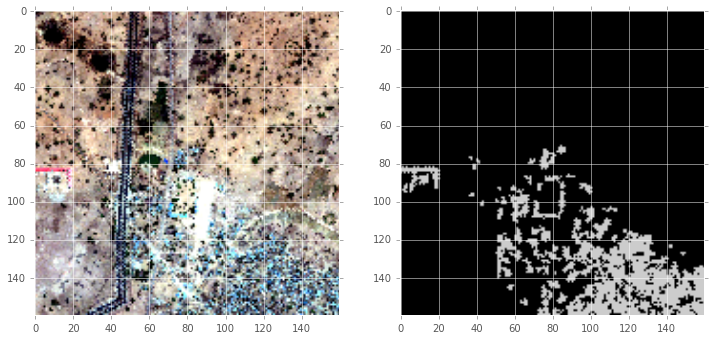

In [259]:
def plot_all(c):
    fig = plt.figure(figsize=(12,12))
    i = np.random.choice(400)
    print(i)
    ax1 = fig.add_subplot(221)
    ax1.imshow(np.rollaxis(x[i,...],0,3)[:,:,:3])

    ax2 = fig.add_subplot(222)
    ax2.imshow(y[i,c,...],cmap='spectral')
    
    plt.show()
plot_all(0)
#push('PICTURES!','The plots are ready')

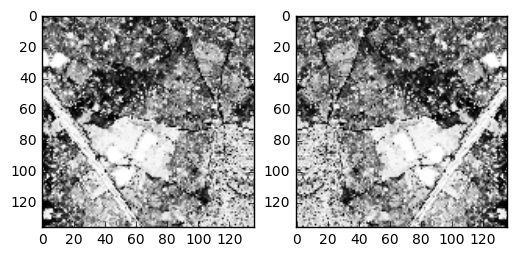

In [65]:
def plot_all(c):
    fig = plt.figure(figsize=(6,6))
    ax1 = fig.add_subplot(221)
    ax1.imshow(x[0,0,:,::-1],cmap='Greys')

    ax2 = fig.add_subplot(222)
    ax2.imshow(x[0,0,:,:],cmap='Greys')
    
    plt.show()
plot_all(5)
#push('PICTURES!','The plots are ready')

In [37]:
def plot_all(i,classType):
    fig = plt.figure(figsize=(6,6))

    ax1 = fig.add_subplot(121)
    ax1.imshow(x[i,1,...],cmap='Greys')

    ax2 = fig.add_subplot(122)
    ax2.imshow(y[i,classType,...].astype(np.float32),cmap='spectral')
    
    plt.show()
#plot_all(2,2,classType,0.5)
#push('PICTURES!','The plots are ready')

50


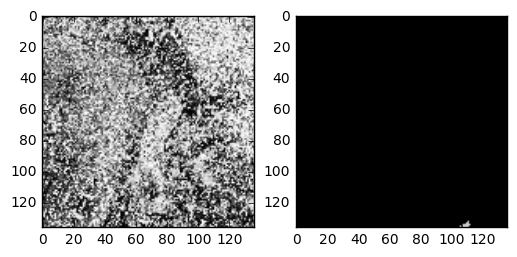

In [43]:
i = np.random.choice(range(50,75),1)[0]
print(i)
plot_all(i,3)